Preparation
===

In [1]:
import sys
REQUIRE_PY_VERSION = (3, 8)
if sys.version_info < REQUIRE_PY_VERSION:
    raise Exception("Python {}.{} or later is required.".format(*REQUIRE_PY_VERSION))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from geoalchemy2 import Geometry, WKTElement
from shapely.geometry import Point, Polygon, MultiPolygon

from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras

import json

We connect to the database using the following function and our credentials.

In [3]:
def connect(credential_path, db_schema="public"):
    with open(credential_path) as f:
        credential = json.load(f)

    host     = credential["host"]
    user     = credential["user"]
    password = credential["password"]
    database = credential["user"]
    
    db, conn = None, None
    try:
        db = create_engine(
            f"postgresql+psycopg2://{user}:{password}@{host}/{database}",
            echo=False
        )
        conn = db.connect()
        print("Connected successfully.")
    except Exception as e:
        print(f"Unable to connect: {e}")
    
    return db, conn

db, conn = connect("Credentials.json")

Connected successfully.


The `query` function is a simple wrapper around `pd.read_sql_query` that returns a table as a `pd.DataFrame` object.

In [4]:
def sql_exec(conn, cmd):
    conn.execute(cmd)

def sql_query(conn, cmd):
    return pd.read_sql_query(cmd, conn)

In [5]:
GDA94_SRID = 4283  # Geocentric Datum Of Australia 1994
WGS84_SRID = 4326  # commonly know as GPS
CEA_PROJ = "+proj=cea"  # Cylindrical Equal Area projection

Building Database
===

We have seven datasets that we use for greater Sydney livability analysis.

The following five datasets are given to us by the academic tutors

- [Statistical Area Level 2 Dataset](#Statistical-Area-Level-2-Dataset) </br>
  Source: [Australian Bureau of Statistics](https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.004July%202016?OpenDocument)
- [Business Statistics Dataset](#Business-Statistics-Dataset) </br>
  Source: Australian Bureau of Statistics published before 2016 _[Counts of Australian Businesses, including Entries and Exits](https://www.abs.gov.au/statistics/economy/business-indicators/counts-australian-businesses-including-entries-and-exits/latest-release)_, accessed 2022
- [Neighbourhood Dataset](#Neighbourhood-Dataset) </br>
  Source: Australian Bureau of Statistics published before 2016 _Unknown Source_, accessed 2022
- [Break and Enter Dataset](#Break-and-Enter-Dataset) </br>
  Source: [NSW Bureau of Crime Statistics and Research](https://www.bocsar.nsw.gov.au/Pages/bocsar_datasets/Spatial.aspx) marked as "Open Data"
- [School Catchment Dataset](#School-Catchment-Dataset) </br>
  Source: [NSW Department of Education](https://data.cese.nsw.gov.au/data/dataset/school-intake-zones-catchment-areas-for-nsw-government-schools) under Creative Commons Attribution License (cc-by)

The following two are only used for the City of Sydney Analysis.
- [Rain Gardens Dataset](#Rain-Gardens-Dataset) </br>
  Source: [City of Sydney Data Hub](https://data.cityofsydney.nsw.gov.au/datasets/cityofsydney::rain-gardens/about) under Creative Commons Attribution 4.0 International (CC BY 4.0)
- [Car Share Dataset](#Car-Share-Dataset) </br>
  Source: [City of Sydney Data Hub](https://data.cityofsydney.nsw.gov.au/datasets/cityofsydney::car-share-bay-operator/about) under Creative Commons Attribution 4.0 International (CC BY 4.0)

![Database Diagram](./res/database_diagram.png)

Statistical Area Level 2 Dataset
---

This dataset conatins all the statistical areas (SA) at level 2 and their enclosing SA at level 3 and 4. It also includes the geometry of that area as a polygon or multiple polygons. We assume the data is in the Geocentric Datum of Australia 1994 (GDA94). The `srid` of this coordinate system is `3577`.

In [6]:
stats_area_raw_df = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")
stats_area_raw_df

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,"MULTIPOLYGON (((96.83047 -12.17636, 96.83045 -..."
2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,"MULTIPOLYGON (((150.69566 -35.18297, 150.69555..."
2307,901041004,91004,Norfolk Island,90104,Norfolk Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,38.6509,"MULTIPOLYGON (((167.99472 -29.04534, 167.99432..."
2308,997979799,99799,Migratory - Offshore - Shipping (OT),99797,Migratory - Offshore - Shipping (OT),997,Migratory - Offshore - Shipping (OT),99799,Migratory - Offshore - Shipping (OT),9,Other Territories,0.0000,None


Our area of concern is Greater Sydney so we filter out only areas in Greater Sydney. We also select only the level 2 id and name columns that we are interested in, and rename them so that they are consistent in our database.

In [7]:
stats_area_df = stats_area_raw_df.copy()
stats_area_df = stats_area_df[stats_area_df["GCC_NAME16"] == "Greater Sydney"]
stats_area_df = stats_area_df[["SA2_MAIN16", "SA2_NAME16", "SA3_NAME16", "geometry"]]
stats_area_df.rename(columns={
    "SA2_MAIN16": "area_id",
    "SA2_NAME16": "area_name",
    "SA3_NAME16": "lvl3_name"
}, inplace=True)
stats_area_df.reset_index(drop=True, inplace=True)

stats_area_df["area_id"] = stats_area_df["area_id"].astype("int64")

stats_area_df

,area_id,area_name,lvl3_name,geometry
0,102011028,Avoca Beach - Copacabana,Gosford,"POLYGON ((151.41373 -33.46559, 151.41361 -33.4..."
1,102011029,Box Head - MacMasters Beach,Gosford,"POLYGON ((151.35398 -33.49854, 151.35397 -33.4..."
2,102011030,Calga - Kulnura,Gosford,"MULTIPOLYGON (((151.20460 -33.53298, 151.20456..."
3,102011031,Erina - Green Point,Gosford,"POLYGON ((151.36795 -33.43822, 151.36791 -33.4..."
4,102011032,Gosford - Springfield,Gosford,"POLYGON ((151.31006 -33.42699, 151.31020 -33.4..."
...,...,...,...,...
307,128021537,Royal National Park,Sutherland - Menai - Heathcote,"POLYGON ((151.07165 -34.05795, 151.07141 -34.0..."
308,128021538,Sutherland - Kirrawee,Sutherland - Menai - Heathcote,"POLYGON ((151.05049 -34.02006, 151.05098 -34.0..."
309,128021607,Engadine,Sutherland - Menai - Heathcote,"POLYGON ((150.99568 -34.05362, 150.99569 -34.0..."
310,128021608,Loftus - Yarrawarrah,Sutherland - Menai - Heathcote,"POLYGON ((151.03954 -34.04176, 151.03954 -34.0..."


Here, we defined two functions that will be used repeatedly throughout our data injection process. These functions convert the more Pythonic `shapely.Polygon` or `shapely.MultiPolygon` objects to `geoalchemy.WKTElement` types that can be injected into our SQL database. We then use them to inject the statiscal areas dataset into our SQL database.

In [8]:
def to_wkt(shape):
    if shape.geom_type == "Polygon":
        shape = MultiPolygon([shape])
    return WKTElement(shape.wkt, GDA94_SRID)

In [9]:
def df_to_wkt(df, srid=GDA94_SRID, column="geometry"):
    df_wkt = df.copy()
    if column in df:
        df_wkt["geom"] = df_wkt[column].apply(to_wkt)
        df_wkt.drop(columns=[column], inplace=True)
    return df_wkt

In [10]:
sql_exec(conn,
    f"""
    drop table if exists stats_area cascade;
    create table stats_area
    (
        area_id   bigint not null
            constraint stats_area_pk
                primary key,
        area_name text,
        lvl3_name text,
        geom  geometry(multipolygon, {GDA94_SRID})
    );
    """
)

stats_area_wkt = df_to_wkt(stats_area_df)

stats_area_wkt.to_sql(
    "stats_area",
    conn,
    index=False,
    if_exists="append",
    dtype={"geom": Geometry("multipolygon", GDA94_SRID)}
)

Business Statistics Dataset
---

The business statistics table records the numbers and types of businesses in each area.

In [11]:
business_stats_raw_df = pd.read_csv("BusinessStats.csv")
business_stats_raw_df

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


We rename the long column names to short and consistent names.

In [12]:
business_stats_df = business_stats_raw_df[[
    "area_id",
    "area_name",
    "accommodation_and_food_services",
    "retail_trade",
    "health_care_and_social_assistance"
]].copy()

business_stats_df.rename(columns={
    "accommodation_and_food_services": "accomm",
    "retail_trade": "retail",
    "health_care_and_social_assistance": "health"
}, inplace=True)

business_stats_df = (
    business_stats_df[business_stats_df["area_id"]
    .isin(stats_area_df["area_id"])]
)

business_stats_df

,area_id,area_name,accomm,retail,health
27,102011028,Avoca Beach - Copacabana,33,35,60
28,102011029,Box Head - MacMasters Beach,23,45,43
29,102011030,Calga - Kulnura,14,43,12
30,102011031,Erina - Green Point,68,145,179
31,102011032,Gosford - Springfield,94,167,246
...,...,...,...,...,...
571,128021537,Royal National Park,3,0,0
572,128021538,Sutherland - Kirrawee,73,113,127
573,128021607,Engadine,37,69,82
574,128021608,Loftus - Yarrawarrah,9,20,25


We inject the table into our SQL database.

In [13]:
sql_exec(conn,
    """
    drop table if exists business_stats cascade;
    create table business_stats
    (
        area_id   bigint not null
            constraint business_stats_pk
                primary key
            references stats_area (area_id),
        area_name text,
        accomm     integer,
        retail    integer,
        health    integer
    );
    """
)

business_stats_df.to_sql(
    "business_stats",
    conn,
    if_exists="append",
    index=False
)

Neighbourhoods
---

The neighbourhoods dataset contains the population and financial data of people in all the areas.

In [14]:
neighbourhoods_raw_df = pd.read_csv("Neighbourhoods.csv")
neighbourhoods_raw_df

,Unnamed: 0,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19
0,0,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0,467,583,604,560
1,1,102011029,Box Head - MacMasters Beach,3208.6000,10986,3847,907.0,42621.0,1682.0,586,696,661,692
2,2,102011030,Calga - Kulnura,76795.1000,4841,1575,1102.0,42105.0,1182.0,220,254,304,320
3,3,102011031,Erina - Green Point,3379.3000,14237,4450,1666.0,43481.0,1595.0,695,778,916,838
4,4,102011032,Gosford - Springfield,1691.2000,19385,6373,2126.0,45972.0,1382.0,1200,1079,963,977
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,317,106011109,Cessnock Region,1570.4341,"7,931","3,281",673.0,73164.0,1080.0,432,590,577,527
318,318,106011113,Singleton Region,4067.2349,"4,919","2,055",698.0,87984.0,1000.0,310,394,353,323
319,319,111021218,Morisset - Cooranbong,330.5208,"14,959","6,298",1154.0,58084.0,1260.0,813,855,828,962
320,320,114021285,Hill Top - Colo Vale,174.3752,"6,025","2,249",400.0,81120.0,1512.0,443,500,470,451


In [15]:
age_intervals = ["0-4", "5-9", "10-14", "15-19"]

neighbourhoods_df = neighbourhoods_raw_df[[
    "area_id",
    "area_name",
    "land_area",
    "population",
    "median_annual_household_income",
    "avg_monthly_rent",
    *age_intervals
]].copy()

neighbourhoods_df.rename(columns={
    "median_annual_household_income": "median_income"
}, inplace=True)

neighbourhoods_df = (
    neighbourhoods_df[neighbourhoods_df["area_id"]
    .isin(stats_area_df["area_id"])]
)

There are entries without valid population data.

In [16]:
neighbourhoods_df[neighbourhoods_df["population"].isna()]

,area_id,area_name,land_area,population,median_income,avg_monthly_rent,0-4,5-9,10-14,15-19
194,123021439,Holsworthy Military Area,12982.3,NaN,NaN,NaN,0,0,0,0


The only area without valid population data is a military area. It is reasonable to not consider this area in our liveability study.

In [17]:
neighbourhoods_df.dropna(subset=["population"], inplace=True)

Some population entries contain thousand separators while others does not. Pandas treated the whole column as `str`. We remove the commas in the column and convert is back to interger.

In [18]:
neighbourhoods_df["population"] = (
    neighbourhoods_df["population"]
    .str.replace(",", "")
    .astype(int)
)

We define **young people** to be people between the age of $0$-$19$. This is the sum of all the columns of population within specific age intervals.

In [19]:
neighbourhoods_df["young_pop"] = neighbourhoods_df.loc[:,age_intervals].sum(axis=1)

neighbourhoods_df.drop(columns=age_intervals, inplace=True)

neighbourhoods_df

,area_id,area_name,land_area,population,median_income,avg_monthly_rent,young_pop
0,102011028,Avoca Beach - Copacabana,643.8,7590,46996.0,1906.0,2214
1,102011029,Box Head - MacMasters Beach,3208.6,10986,42621.0,1682.0,2635
2,102011030,Calga - Kulnura,76795.1,4841,42105.0,1182.0,1098
3,102011031,Erina - Green Point,3379.3,14237,43481.0,1595.0,3227
4,102011032,Gosford - Springfield,1691.2,19385,45972.0,1382.0,4219
...,...,...,...,...,...,...,...
307,128021537,Royal National Park,13933.4,28,NaN,1899.0,8
308,128021538,Sutherland - Kirrawee,775.5,21760,53378.0,1809.0,4894
309,128021607,Engadine,895.4,17424,52667.0,1955.0,5176
310,128021608,Loftus - Yarrawarrah,384.4,7426,51243.0,2163.0,2054


Now our neighbourhood population and financial data is ready to be injected into the SQL databse.

In [20]:
sql_exec(conn,
    """
    drop table if exists neighbourhoods cascade;
    create table neighbourhoods
    (
        area_id    bigint not null
            constraint neighbourhoods_pk
                primary key
            references stats_area (area_id),
        area_name  varchar not null,
        land_area  float,
        population integer,
        median_income float,
        avg_monthly_rent float,
        young_pop  integer
    );
    """
)

neighbourhoods_df.to_sql(
    "neighbourhoods",
    conn,
    if_exists="append",
    index=False
)

Break and Enter Dataset
---



In [21]:
break_enter_raw_df = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")
break_enter_raw_df

,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,geometry
0,1,8.0,Low Density,1,0.012138,0.000006,"POLYGON ((149.91078 -37.06636, 149.91080 -37.0..."
1,2,8.0,Low Density,1,0.019106,0.000015,"POLYGON ((149.90601 -37.05837, 149.90602 -37.0..."
2,3,8.0,Low Density,1,0.006068,0.000002,"POLYGON ((148.94250 -37.04209, 148.94253 -37.0..."
3,4,8.0,Low Density,1,0.011006,0.000006,"POLYGON ((149.19583 -36.91833, 149.19584 -36.9..."
4,5,8.0,Low Density,1,0.008073,0.000003,"POLYGON ((149.84836 -36.68459, 149.84838 -36.6..."
...,...,...,...,...,...,...,...
2589,2590,10.0,High Density,3,0.015358,0.000011,"POLYGON ((153.27961 -28.55388, 153.27964 -28.5..."
2590,2591,10.0,High Density,3,0.028327,0.000029,"POLYGON ((150.35939 -28.60530, 150.35941 -28.6..."
2591,2592,10.0,High Density,3,0.006654,0.000002,"POLYGON ((153.56825 -28.38307, 153.56828 -28.3..."
2592,2593,10.0,High Density,3,0.047098,0.000044,"POLYGON ((153.53917 -28.18858, 153.53920 -28.1..."


In [22]:
f'{break_enter_raw_df["geometry"].crs.name = !s}'

'break_enter_raw_df["geometry"].crs.name = WGS 84'

We can see that the raw data is of a different coordinate reference system than the other datasets. To unify our database for easier join operations and/or area calculations, we would like to use GDA94 for all tables.

In [23]:
break_enter_df = break_enter_raw_df[[
    "OBJECTID",
    "geometry"
]].copy()

break_enter_df.rename(columns={
    "OBJECTID": "id"
}, inplace=True)

break_enter_df.to_crs(GDA94_SRID, inplace=True)

break_enter_df

,id,geometry
0,1,"POLYGON ((149.91077 -37.06638, 149.91079 -37.0..."
1,2,"POLYGON ((149.90600 -37.05838, 149.90602 -37.0..."
2,3,"POLYGON ((148.94249 -37.04210, 148.94253 -37.0..."
3,4,"POLYGON ((149.19583 -36.91835, 149.19584 -36.9..."
4,5,"POLYGON ((149.84835 -36.68460, 149.84837 -36.6..."
...,...,...
2589,2590,"POLYGON ((153.27960 -28.55389, 153.27964 -28.5..."
2590,2591,"POLYGON ((150.35939 -28.60531, 150.35940 -28.6..."
2591,2592,"POLYGON ((153.56824 -28.38308, 153.56827 -28.3..."
2592,2593,"POLYGON ((153.53916 -28.18859, 153.53919 -28.1..."


In [24]:
sql_exec(conn,
    f"""
    drop table if exists break_enter cascade;
    create table break_enter
    (
        id    bigint not null
            constraint break_enter_pk
                primary key,
        geom  geometry(multipolygon, {GDA94_SRID})
    );
    """
)

break_enter_wkt = df_to_wkt(break_enter_df, srid=GDA94_SRID)

break_enter_wkt.to_sql(
    "break_enter",
    conn,
    index=False,
    if_exists="append",
    dtype={"geom": Geometry("multipolygon", GDA94_SRID)}
)

School Catchment Dataset
---



In [25]:
school_primary_raw_df = gpd.read_file("school_catchments/catchments_primary.shp")
school_secondary_raw_df = gpd.read_file("school_catchments/catchments_secondary.shp")
school_future_raw_df = gpd.read_file("school_catchments/catchments_future.shp")
school_catch_raw_df = pd.concat([
    school_primary_raw_df,
    school_secondary_raw_df,
    school_future_raw_df
])
school_catch_raw_df

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,3943,PRIMARY,Gordon WPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.14085 -33.74463, 151.14113 -33.7..."
2,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
3,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
4,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,4680,PRIMARY,Googong PS,20220305,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,NaN,"POLYGON ((149.26653 -35.49838, 149.26703 -35.5..."
40,2540,PRIMARY,Michelago PS,20220305,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,NaN,"POLYGON ((149.14237 -35.56872, 149.16075 -35.5..."
41,8922,HIGH_COED,Jerrabomberra HS,20220305,0,0,0,0,0,0,0,2023,2023,0,0,0,0,NaN,"POLYGON ((149.19808 -35.38147, 149.19852 -35.3..."
42,8919,HIGH_COED,Bungendore HS,20220305,0,0,0,0,0,0,0,2023,2023,0,0,0,0,NaN,"POLYGON ((149.24085 -34.91439, 149.24367 -34.9..."


In [26]:
school_df = school_catch_raw_df[[
    "USE_ID",
    "USE_DESC",
]].copy()

school_df.rename(columns={
    "USE_ID": "id",
    "USE_DESC": "name",
}, inplace=True)

school_df = school_df[~school_df.duplicated()]

school_df

,id,name
0,2838,Parklea PS
1,3943,Gordon WPS
2,2404,Lindfield EPS
3,4393,Carlingford WPS
4,4615,Caddies Ck PS
...,...,...
2,4683,Murrumbateman PS
30,4678,Epping South PS
39,4680,Googong PS
41,8922,Jerrabomberra HS


In [27]:
catchment_df = school_catch_raw_df[[
    "USE_ID",
    "geometry",
]].copy()

catchment_df.rename(columns={
    "USE_ID": "id",
}, inplace=True)

catchment_df

,id,geometry
0,2838,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,3943,"POLYGON ((151.14085 -33.74463, 151.14113 -33.7..."
2,2404,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
3,4393,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
4,4615,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
...,...,...
39,4680,"POLYGON ((149.26653 -35.49838, 149.26703 -35.5..."
40,2540,"POLYGON ((149.14237 -35.56872, 149.16075 -35.5..."
41,8922,"POLYGON ((149.19808 -35.38147, 149.19852 -35.3..."
42,8919,"POLYGON ((149.24085 -34.91439, 149.24367 -34.9..."


In [28]:
sql_exec(conn,
    f"""
    drop table if exists catchment cascade;
    drop table if exists school cascade;
    
    create table school
    (
        id    bigint not null
            constraint school_pk
                primary key,
        name  text
    );
    create table catchment
    (
        id   bigint not null
            constraint catchment_school_id_fk
                references school,
        geom geometry(MultiPolygon, {GDA94_SRID})
    );
    """
)

school_df.to_sql(
    "school",
    conn,
    index=False,
    if_exists="append"
)

catchment_wkt = df_to_wkt(catchment_df)

catchment_wkt.to_sql(
    "catchment",
    conn,
    index=False,
    if_exists="append",
    dtype={"geom": Geometry("multipolygon", GDA94_SRID)}
)

Greater Sydney Liveability Analysis
===

Livability Score
---

We define the **livability score** using the following formula.

$$
\text{livability score} = S\left(z_{\text{school}} + z_{\text{accomm}} + z_{\text{retail}} − z_{\text{crime}} + z_{\text{health}}\right)
$$

where $z_\text{value}$ is the z-score of the respective values.

### Break and Enter View

We first calculate the sum of all crime geometries within each SA2. We create a `materialized view` for it so that results are cached and reduces our time of repeated queries.

In [29]:
sql_exec(conn,
    f"""
    drop materialized view if exists break_enter_area cascade;
    create materialized view break_enter_area as
    SELECT sa.area_id,
           sa.area_name,
           COALESCE(sum(st_area(st_intersection(sa.geom, be.geom))), 0) AS crime
    FROM stats_area sa
             LEFT JOIN break_enter be ON st_intersects(sa.geom, be.geom)
    GROUP BY sa.area_id, sa.area_name
    ORDER BY crime;
    """
)

break_enter_area_df = sql_query(conn,
    """
    select *
    from break_enter_area
    """
)

break_enter_area_df

,area_id,area_name,crime
0,128021608,Loftus - Yarrawarrah,0.000000
1,102011028,Avoca Beach - Copacabana,0.000000
2,102011030,Calga - Kulnura,0.000000
3,121021404,Berowra - Brooklyn - Cowan,0.000000
4,128021609,Woronora Heights,0.000000
...,...,...,...
307,116031313,Bidwill - Hebersham - Emerton,0.000964
308,124031462,Kingswood - Werrington,0.000968
309,116031316,Lethbridge Park - Tregear,0.001128
310,125041492,Parramatta - Rosehill,0.001297


We verify that our calculation is in fact correct by plotting a graph of all the SA2 coloured by the break and enter area sum under all the break and enter spots.

In [30]:
# Join Greater Sydney SA2 with break and enter area sums
sa2_break_enter_df = stats_area_df.merge(
    break_enter_area_df,
    on=["area_id", "area_name"]
).sort_values("crime").reset_index()
sa2_break_enter_df

,index,area_id,area_name,lvl3_name,geometry,crime
0,0,102011028,Avoca Beach - Copacabana,Gosford,"POLYGON ((151.41373 -33.46559, 151.41361 -33.4...",0.000000
1,64,116031318,Prospect Reservoir,Mount Druitt,"POLYGON ((150.87171 -33.78717, 150.87185 -33.7...",0.000000
2,70,117011324,Port Botany Industrial,Botany,"POLYGON ((151.22090 -33.96897, 151.22066 -33.9...",0.000000
3,71,117011325,Sydney Airport,Botany,"POLYGON ((151.16260 -33.93277, 151.16269 -33.9...",0.000000
4,104,119011355,Chullora,Bankstown,"POLYGON ((151.02884 -33.88798, 151.02987 -33.8...",0.000000
...,...,...,...,...,...,...
307,59,116031313,Bidwill - Hebersham - Emerton,Mount Druitt,"POLYGON ((150.81005 -33.73492, 150.81003 -33.7...",0.000964
308,217,124031462,Kingswood - Werrington,Penrith,"POLYGON ((150.71266 -33.75426, 150.71300 -33.7...",0.000968
309,62,116031316,Lethbridge Park - Tregear,Mount Druitt,"POLYGON ((150.77878 -33.74002, 150.77870 -33.7...",0.001128
310,251,125041492,Parramatta - Rosehill,Parramatta,"POLYGON ((150.99428 -33.81943, 150.99432 -33.8...",0.001297


In [31]:
try:
    import pygeos
except ImportError:
    pass
else:
    raise Exception("Please uninstall pygeos before continuing")

# Filter only break and enter in Greater Sydney
syd_geom = stats_area_df["geometry"].unary_union
syd_break_enter_df = break_enter_df[break_enter_df["geometry"].intersects(syd_geom)]
syd_break_enter_df

,id,geometry
180,181,"POLYGON ((150.58652 -34.29505, 150.58654 -34.2..."
181,182,"POLYGON ((150.58077 -34.28754, 150.58079 -34.2..."
192,193,"POLYGON ((150.59366 -34.21811, 150.59368 -34.2..."
197,198,"POLYGON ((150.57961 -34.20678, 150.57963 -34.2..."
199,200,"POLYGON ((150.71111 -34.18175, 150.71113 -34.1..."
...,...,...
2418,2419,"POLYGON ((151.49778 -33.34450, 151.49781 -33.3..."
2420,2421,"POLYGON ((151.42192 -33.28083, 151.42195 -33.2..."
2421,2422,"POLYGON ((151.54281 -33.26834, 151.54288 -33.2..."
2422,2423,"POLYGON ((151.51404 -33.25267, 151.51409 -33.2..."


In [32]:
# Compute the centroids of all break and enter spots
syd_break_enter_centroid = (
    syd_break_enter_df["geometry"]
    .to_crs(CEA_PROJ)
    .centroid
    .to_crs(GDA94_SRID)
)

In [33]:
from matplotlib.offsetbox import AnchoredText

def ax_mark_gda94(ax):
    """
    Marks a graph as GDA94 in the top left corner.
    """
    at = AnchoredText(
        "GDA94", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

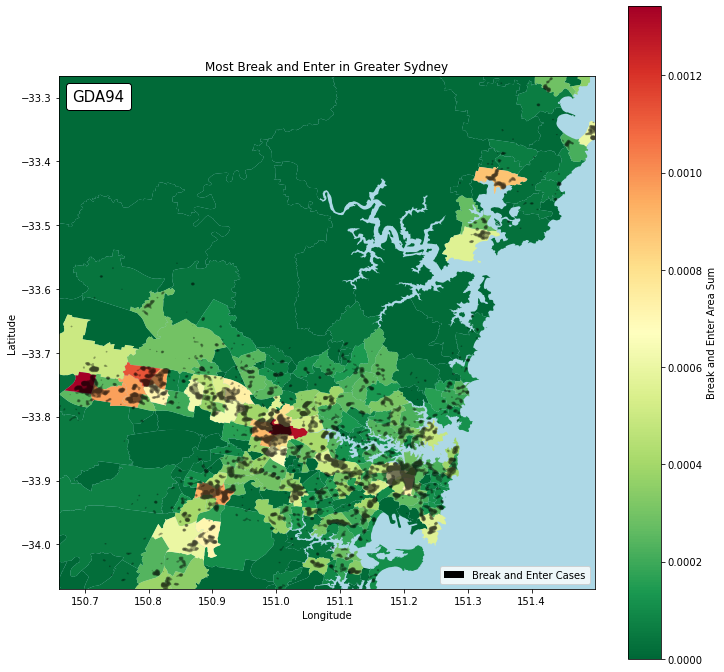

In [34]:
from matplotlib.patches import Patch

exclude_low = 0.025  # increase to exclude more far out crimes
exclude_hgh = 1 - exclude_low
x_min = syd_break_enter_centroid.x.quantile(exclude_low)
x_max = syd_break_enter_centroid.x.quantile(exclude_hgh)
y_min = syd_break_enter_centroid.y.quantile(exclude_low)
y_max = syd_break_enter_centroid.y.quantile(exclude_hgh)

fig, ax = plt.subplots(figsize=(12, 12))

sa2_break_enter_df.plot(
    ax=ax,
    cmap="RdYlGn_r",
    column="crime",
    legend=True,
    legend_kwds={"label": "Break and Enter Area Sum"}
)
syd_break_enter_df.plot(ax=ax, color="black", alpha=1/3, label="Break and Enter Areas")

ax.set_title("Most Break and Enter in Greater Sydney")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.set_facecolor("lightblue")
ax.legend(
    handles=[Patch(
        facecolor="black",
        label="Break and Enter Cases")],
    loc="lower right"
)
ax.set_aspect("equal", adjustable="box")
ax_mark_gda94(ax)

plt.plot();

The map indicates that our computation of the break and enter area sum is correct. We are expecting the SA2 with more and darker black spots to be redder and the opposite to be greener. And this is indeed what the map shows.

We create a function to save this graph and future graphs in this report.

In [35]:
import os

def savefig(fig, ax, dir_="fig", ext=".png"):
    if fig._suptitle is not None:
        name = fig._suptitle.get_text()
    else:
        name = ax.get_title()
    if not name:
        name = "unnamed"
    name = name.lower().replace(" ", "_")
    path = os.path.join(dir_, name + ext)
    if not os.path.exists(dir_):
        os.mkdir(dir_)
    fig.savefig(path)
    print(f"saved to {path}")

In [36]:
savefig(fig, ax)

saved to fig/most_break_and_enter_in_greater_sydney.png


### School Catchment View

We also make a view for the number of intersecting school catchments zones each SA2 has.

In [37]:
sql_exec(conn,
    """
    drop materialized view if exists catchment_counts cascade;
    create materialized view catchment_counts(area_id, area_name, count) as
    SELECT sa.area_id,
           sa.area_name,
           count(c.id)
    FROM stats_area sa
             LEFT JOIN catchment c ON st_intersects(sa.geom, c.geom)
    GROUP BY sa.area_id, sa.area_name
    ORDER BY count DESC;
    """
)

catchment_counts_df = sql_query(conn,
    """
    select *
    from catchment_counts
    """
)

catchment_counts_df

,area_id,area_name,count
0,127011506,Cobbitty - Leppington,36
1,116021312,Riverstone - Marsden Park,35
2,115021297,Dural - Kenthurst - Wisemans Ferry,34
3,102011030,Calga - Kulnura,27
4,124021456,Blue Mountains - South,27
...,...,...,...
307,121041417,North Sydney - Lavender Bay,4
308,102011033,Kariong,4
309,128011605,Lilli Pilli - Port Hacking - Dolans Bay,3
310,122021420,Avalon - Palm Beach,3


### Livability Score Overview

Now that we had the crime and enter, and school catchment data prepared, we can assemble the tables together and compute the final livability score with the formula we defined at the start of this section [Livability Score](#Livability-Score).

We first create a sigmoid function in our SQL database for later use.

$$
S(x) = \frac{1}{1 + e^{-x}}
$$

In [38]:
sql_exec(conn,
    """
    create or replace function sigmoid(i numeric) returns numeric as
    $$
    begin
        return 1 / (1 + exp(-i));
    end;
    $$ language plpgsql;
    """
)

We check that the sigmoid function works by feeding it some random data and plotting the result.

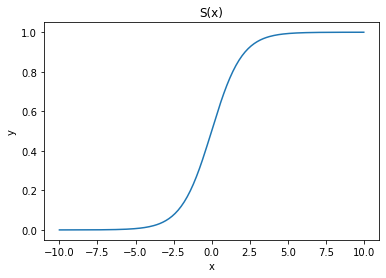

In [39]:
sql_query(conn,
    """
    with series as (select generate_series(-10, 10, 0.1) as x)
    select x, sigmoid(x)
    from series
    """
).plot(
    x="x",
    y="sigmoid",
    title="S(x)",
    ylabel="y",
    legend=False
);

In [40]:
sql_exec(conn,
    """
    drop view if exists scores cascade;
    create view scores as
    (
    with full_table as (select sa.area_id,
                               sa.area_name,
                               accomm::numeric / nullif(population, 0) * 1000  as accomm,
                               retail::numeric / nullif(population, 0) * 1000 as retail,
                               health::numeric / nullif(population, 0) * 1000 as health,
                               crime::numeric / nullif(land_area, 0)          as crime,
                               cc.count::numeric / nullif(young_pop, 0)       as school
                        from stats_area sa
                                 join business_stats bs on sa.area_id = bs.area_id
                                 join neighbourhoods n on sa.area_id = n.area_id
                                 join break_enter_area bea on sa.area_id = bea.area_id
                                 join catchment_counts cc on sa.area_id = cc.area_id),
         stats as (select avg(accomm)     as avg_accomm,
                          stddev(accomm)  as stddev_accomm,
                          avg(retail)    as avg_retail,
                          stddev(retail) as stddev_retail,
                          avg(health)    as avg_health,
                          stddev(health) as stddev_health,
                          avg(crime)     as avg_crime,
                          stddev(crime)  as stddev_crime,
                          avg(school)    as avg_school,
                          stddev(school) as stddev_school
                   from full_table),
         z_scores as (select area_id,
                             area_name,
                             coalesce((accomm - avg_accomm) / stddev_accomm, 0) as z_accomm,
                             coalesce((retail - avg_retail) / stddev_retail, 0) as z_retail,
                             coalesce((health - avg_health) / stddev_health, 0) as z_health,
                             coalesce((crime - avg_crime) / stddev_crime, 0)    as z_crime,
                             coalesce((school - avg_school) / stddev_school, 0) as z_school
                      from full_table,
                           stats)
    select area_id,
           area_name,
           sigmoid((z_accomm + z_retail + z_health - z_crime + z_school)::numeric) as score,
           z_accomm,
           z_retail,
           z_health,
           z_crime,
           z_school
    from z_scores
    order by score desc)
    """
)

In [41]:
scores_df = sql_query(conn,
    """
    select *
    from scores
    """
)
pd.set_option('precision', 10)
pd.set_option('display.float_format', lambda x: '%.10f' % x)

In [42]:
def savecsv(df, name, dir_="csv", ext="csv"):
    if not os.path.exists(dir_):
        os.mkdir(dir_)
    path = os.path.join(dir_, f"{name}.{ext}")
    df.to_csv(path)
    print(f"DataFrame saved to {path}")

savecsv(scores_df, "scores")

DataFrame saved to csv/scores.csv


Looking good, we join the table with the geometric data in the statistical area table.

Although there are still a lot of outliers, it is good enough to give us a nice plot. Now we plot the SA2 colored by their livability scores. We also label the names of five most and five least livable areas.

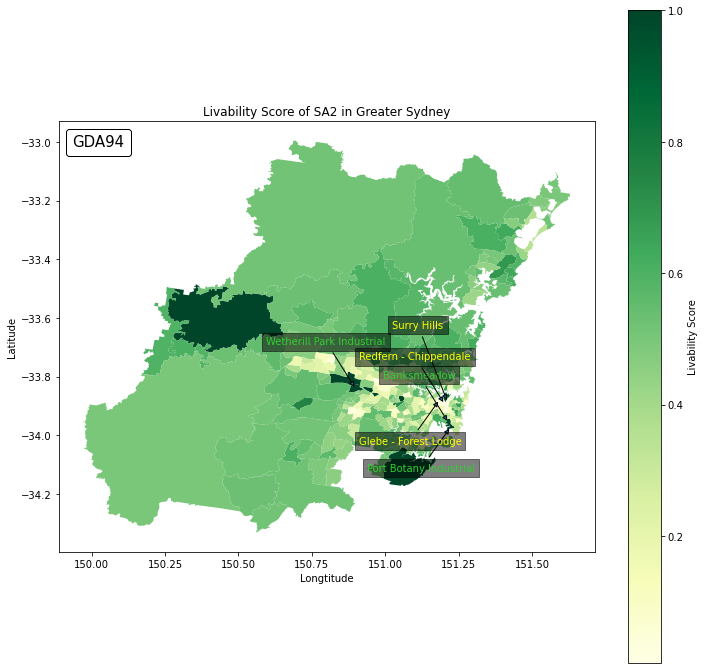

In [43]:
n_head = 3  # number of most livable areas to hightlight
n_tail = 3  # number of least livable areas to hightlight

scores_geom_df = stats_area_df.merge(
    scores_df,
    on=["area_id", "area_name"]
).sort_values("score", ascending=False).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
scores_geom_df.plot(
    ax=ax,
    cmap="YlGn",
    column="score",
    legend=True,
    legend_kwds={"label": "Livability Score"}
)

# Label the most and least livable areas
scores_geom_df["centroid"] = (
    scores_geom_df["geometry"]
    .to_crs(CEA_PROJ)
    .centroid
    .to_crs(GDA94_SRID)
)
xytexts = []
offset_base = 0.05
for idx, row in (scores_geom_df.head(n_head)
                 .append(scores_geom_df.tail(n_tail))
                 .reset_index()
                 .iterrows()):
    xtext = row["centroid"].x - 0.1
    ytext = row["centroid"].y
    offset = offset_base * 3
    while any(abs(xtext - x) < 0.35 and \
              abs(ytext + offset - y) < offset_base for x, y in xytexts):
        offset = -offset if offset > 0 else -offset + offset_base
    ann = ax.annotate(
        text=row["area_name"],
        color="limegreen" if idx < n_head else "yellow",
        xy=(row["centroid"].x, row["centroid"].y),
        xytext=(xtext, ytext + offset),
        arrowprops={"arrowstyle": "-|>"},
        horizontalalignment="center"
    )
    ann.set_bbox({"facecolor": "black", "alpha": .5})
    xytexts.append((xtext, ytext + offset))

ax_mark_gda94(ax)
ax.set_title("Livability Score of SA2 in Greater Sydney")
ax.set_xlabel("Longtitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal", adjustable="box")

plt.plot();

In [44]:
savefig(fig, ax)

saved to fig/livability_score_of_sa2_in_greater_sydney.png


From the table and the graph we can see that the livability in the City of Sydney and Parramatta is the worst. Looking back at the data set, these areas all have high break and enter rates, which significantly dragged down the overall livability score. Note that this score is not computed per capital, but per total area instead. Considering that the areas in the city has higher population and housing density, its business scores may be much lower despite a higher density of such business. Higher housing density also makes these areas more vulnerable to crimes.

In [45]:
scores_df.merge(
    neighbourhoods_df,
    on="area_id"
).merge(
    business_stats_df,
    on="area_id"
).iloc[:3]

,area_id,area_name_x,score,z_accomm,z_retail,z_health,z_crime,z_school,area_name_y,land_area,population,median_income,avg_monthly_rent,young_pop,area_name,accomm,retail,health
0,127021521,Wetherill Park Industrial,1.0000000000,11.4572307745,10.9519417505,16.7812120631,-0.7937541626,10.8220656579,Wetherill Park Industrial,855.7000000000,46,46348.0000000000,NaN,1,Wetherill Park Industrial,29,86,13
1,117011320,Banksmeadow,0.9999999957,7.7237565316,7.1941890297,-0.4230181811,-0.7893603910,3.9831671515,Banksmeadow,336.8000000000,21,49680.0000000000,NaN,2,Banksmeadow,9,26,0
2,117011324,Port Botany Industrial,0.9999998274,7.7237565316,7.4775605463,-0.4230181811,-0.7937541626,0.0000000000,Port Botany Industrial,280.4000000000,7,NaN,NaN,0,Port Botany Industrial,3,9,0


On the other hand, the most livable areas is Wetherill Park Industrial, with a stunning score of $50.8$. It is more than twice of the score of the second place. It is highly due to its low population, but surprisingly high number of businesses. This reflects another problem of our formula for livability score. We assume that people all uses facilities within their respective SA2, neglecting the fact that the businesses could also help people living in other areas. The businesses may as well be overwhelmed by people from surrounding areas. The data also shows that when the population is small, we losses the generality of our formula. For example, the third place in our table is yet another industrial - Port Botany Industrial. It doesn't have any schools, nor does it have any health facilities. However, with its less than 10 population, the other scores scale up quickly and make up its shortage in the these areas.

### Livability Score Factors

There are five z-scores that contribute to our livability score. In the last part, we see that the livability score is biased towards the strongest or weakest areas. Now we take a closer look at the five components.

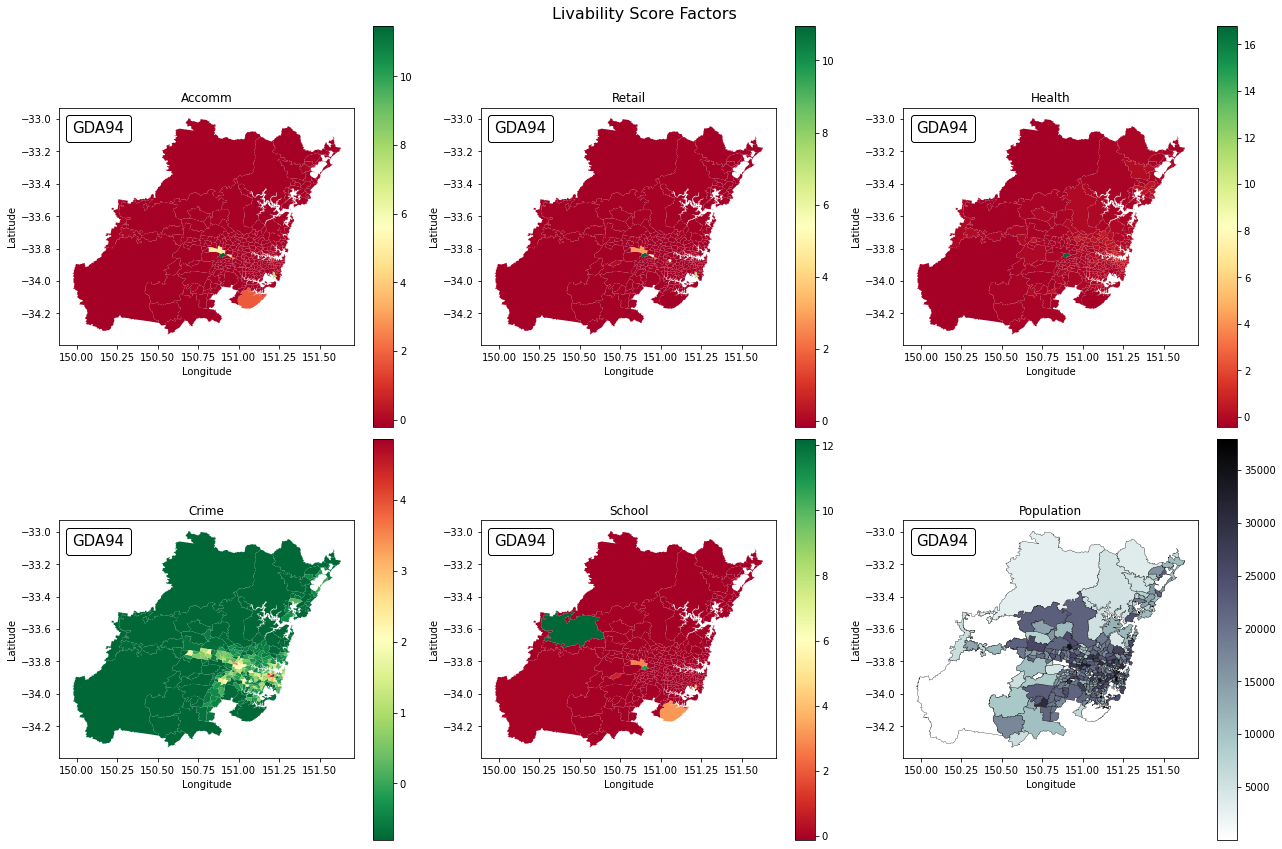

In [46]:
from matplotlib.colors import LinearSegmentedColormap

z_cols = [*filter(lambda s: s.startswith("z_"),
                  scores_df.columns)]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, col in enumerate(z_cols):
    ax = axes.ravel()[idx]
    col_name = col.removeprefix("z_").title()
    cmap="RdYlGn" if col_name != "Crime" else "RdYlGn_r"
    scores_geom_df.plot(ax=ax, column=col, cmap=cmap, legend=True)
    ax.set_title(col_name)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect("equal", adjustable="box")
    ax_mark_gda94(ax)

ax = axes.ravel()[(idx := idx + 1)]
(sa2_break_enter_df
 .merge(neighbourhoods_df, on="area_id")
 .plot(ax=ax, column="population", cmap="bone_r", linewidth=.3, edgecolor="k", legend=True))
ax.set_title("Population")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal", adjustable="box")
ax_mark_gda94(ax)

fig.suptitle("Livability Score Factors", fontsize=16)

plt.tight_layout();

From the graph, we can see that as  suspected, only a few SA2s have insanely high positively contributing scores. Those SA2s also happen to be the few only white spots on the population map. Their low population significantly scaled up the z-scores. On the other hand, the crime z-score in the city of Sydney and Parramatta is very high. _Note that the crime graph is inverted because it negatively contributes towards the livability score._ The hot SA2s in the City and around Parramatta is highly due to them being easier and more tempting targets and their small areas. The crime score is calculated per area instead of per capital. In some way, our formula for livability score is actually disadvantageous to SA2 with higher population and lower area.

In [47]:
savefig(fig, axes)

saved to fig/livability_score_factors.png


Indexing
---



We can benchmark the school catchment view DDL before and after we create an index on the catchment geom. The server has proven to be fairly unreliable, so I commented with the results of one successful run 2 a.m. in the morning.

In [48]:
%%timeit -n1 -r1 sql_exec(conn, "drop index if exists catchment_geom_idx;")

sql_query(conn,
    """
    SELECT sa.area_id,
           sa.area_name,
           count(c.id) AS count
    FROM stats_area sa
             LEFT JOIN catchment c ON st_intersects(sa.geom, c.geom)
    GROUP BY sa.area_id, sa.area_name
    ORDER BY (count(c.id)) DESC;
    """
)
# 4.79 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

1min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [49]:
%%timeit -n1 -r1 sql_exec(conn, "create index catchment_geom_idx on catchment using gist(geom);")

sql_query(conn,
    """
    SELECT sa.area_id,
           sa.area_name,
           count(c.id) AS count
    FROM stats_area sa
             LEFT JOIN catchment c ON st_intersects(sa.geom, c.geom)
    GROUP BY sa.area_id, sa.area_name
    ORDER BY (count(c.id)) DESC;
    """
)
# 547 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

5.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


From the results, we see that creating an index on the geom data of catchment is fairly effective. Similarly, we should also create an index on the geom of break and enter table.

In [50]:
sql_exec(conn,
    """
    drop index if exists break_enter_geom_idx;
    create index break_enter_geom_idx on break_enter using gist(geom);
    """
)

Surprisingly, creating an index on the geom of statistical area doesn't contribute much to the query we are submitting. The reason is described in the PostgreSQL documentation.

> The PostgreSQL query planner intelligently chooses when to use or not to use indexes to evaluate a query. Counter-intuitively, it is not always faster to do an index search: if the search is going to return every record in the table, traversing the index tree to get each record will actually be slower than just sequentially reading the whole table from the start. [[link]](http://postgis.net/workshops/postgis-intro/indexing.html#analyzing)

The query we perform usually returns the entire table, so the index doesn't do much. That being said, it doesn't cost us a lot to create the index anyways, so we also create a spatial index for the statistical areas table.

In [51]:
sql_exec(conn,
    """
    drop index if exists stats_area_geom_idx;
    create index stats_area_geom_idx on stats_area using gist(geom);
    """
)

Correlation between Score, Income, and Rent
---

One may naturally wonder if there is a relationship between the livability score, the average monthly rent, and the median income.

### Correlation between the Score and the Income

This is our data on the livability score and the median annual household income of each SA2.

In [52]:
score_income_df = neighbourhoods_df.merge(
    scores_df,
    on="area_id"
)[["score", "median_income"]].dropna(how="any")
score_income_df

,score,median_income
0,0.6147197511,46996.0000000000
1,0.5405471700,42621.0000000000
2,0.5412257481,42105.0000000000
3,0.6864118400,43481.0000000000
4,0.4409587676,45972.0000000000
...,...,...
305,0.5276944750,55391.0000000000
307,0.3485797267,53378.0000000000
308,0.5190547448,52667.0000000000
309,0.5307387872,51243.0000000000


In [53]:
sql_query(conn,
    """
    select corr(score, median_income) as "corr_score_income"
    from neighbourhoods n
    join scores s on n.area_id = s.area_id
    """
)

,corr_score_income
0,0.0946628518


Our query shows that there is no strong correlation between the livability score we computed and the average monthly rent.

We can visualise this relationship by plotting a scatter plot and a line of best fit.

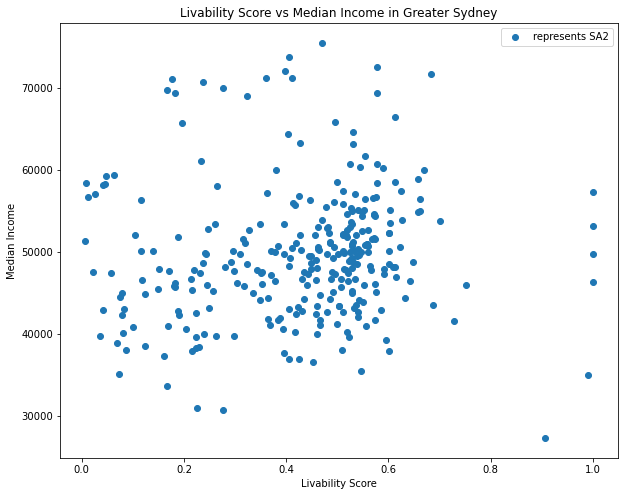

In [54]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(
    x=score_income_df["score"],
    y=score_income_df["median_income"],
    label="represents SA2"
)

ax.set_title("Livability Score vs Median Income in Greater Sydney")
ax.set_xlabel("Livability Score")
ax.set_ylabel("Median Income")
ax.legend()

plt.plot();

In [55]:
savefig(fig, ax)

saved to fig/livability_score_vs_median_income_in_greater_sydney.png


### Correlation between the Score and the Rent

This is our data on the livability score and the average monthly rent of each SA2.

In [56]:
score_rent_df = neighbourhoods_df.merge(
    scores_df,
    on="area_id"
)[["score", "avg_monthly_rent"]].dropna(how="any")
score_rent_df

,score,avg_monthly_rent
0,0.6147197511,1906.0000000000
1,0.5405471700,1682.0000000000
2,0.5412257481,1182.0000000000
3,0.6864118400,1595.0000000000
4,0.4409587676,1382.0000000000
...,...,...
306,0.9939671654,1899.0000000000
307,0.3485797267,1809.0000000000
308,0.5190547448,1955.0000000000
309,0.5307387872,2163.0000000000


In [57]:
sql_query(conn,
    """
    select corr(score, avg_monthly_rent) as "corr_score_rent"
    from neighbourhoods n
    join scores s on n.area_id = s.area_id
    """
)

,corr_score_rent
0,0.2039731831


There is no strong correlation between the livability score we computed and the average monthly rent. Both the score vs the income and the score vs the rent shows poor correlation. There could be two non-mutually-exclusive reasons for that:
- If we assume that our score is a good reflection on livability, it means that people may not care so much about the overall livability in the region, but rather personal factors like the proximity to their workplace etc.
- The formula we used for computing livability score is not accurate. We didn't account for some important factors or the weighting is not optimal.

We can visualise this relationship by plotting a scatter plot and a line of best fit.

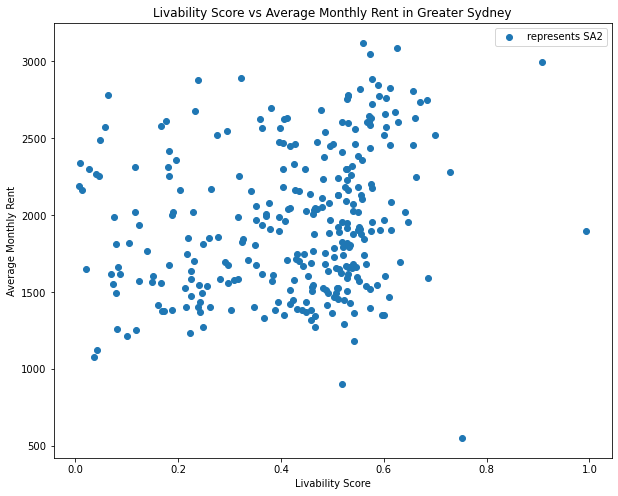

In [58]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(
    x=score_rent_df["score"],
    y=score_rent_df["avg_monthly_rent"],
    label="represents SA2"
)

ax.set_title("Livability Score vs Average Monthly Rent in Greater Sydney")
ax.set_xlabel("Livability Score")
ax.set_ylabel("Average Monthly Rent")
ax.legend()

plt.plot();

In [59]:
savefig(fig, ax)

saved to fig/livability_score_vs_average_monthly_rent_in_greater_sydney.png


### Correlation between the Income and the Rent

This is our data on the median annual household income and the average monthly rent of each SA2.

In [60]:
income_rent_df = neighbourhoods_df[["median_income", "avg_monthly_rent"]].dropna(how="any")
income_rent_df

,median_income,avg_monthly_rent
0,46996.0000000000,1906.0000000000
1,42621.0000000000,1682.0000000000
2,42105.0000000000,1182.0000000000
3,43481.0000000000,1595.0000000000
4,45972.0000000000,1382.0000000000
...,...,...
306,55391.0000000000,1947.0000000000
308,53378.0000000000,1809.0000000000
309,52667.0000000000,1955.0000000000
310,51243.0000000000,2163.0000000000


We can use SQL `corr` function to calculate the correlation index between the two columns.

In [61]:
sql_query(conn,
    """
    select corr(median_income, avg_monthly_rent) as "corr_income_rent"
    from neighbourhoods n
    join scores s on n.area_id = s.area_id
    """
)

,corr_income_rent
0,0.6619190326


The correlation between the median income and the average monthly rent on the other hand is $0.661919$. There is a relatively large and positive correlation between the median income of each SA2 and the average monthly rent in the respective area. After all, people need to have a higher income to pay for a higher rent. Though there is a correlation, the relationship isn't perfectly strong, probably because some people prefer to drain their financial reserves while others may prefer to save up.

We can visualise this relationship by plotting a scatter plot and a line of best fit.

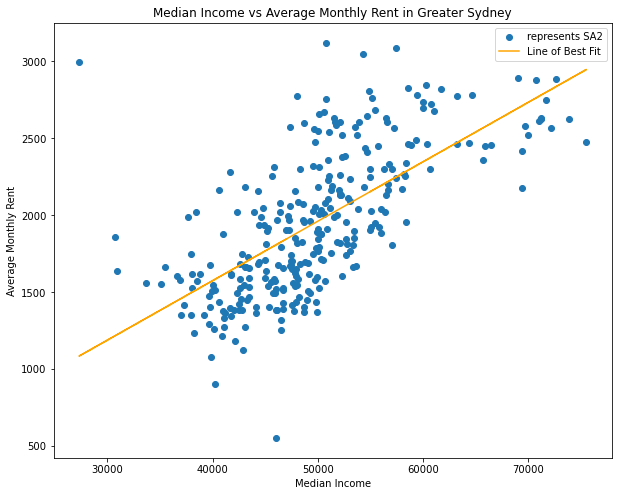

In [62]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 8))

# Line of best fit
x = income_rent_df["median_income"].to_numpy()
y = income_rent_df["avg_monthly_rent"].to_numpy()
m, b = np.polyfit(x, y, 1)
sc = ax.scatter(x, y, label="represents SA2")
ln = ax.plot(x, m * x + b, color="orange", label="Line of Best Fit")

ax.set_title("Median Income vs Average Monthly Rent in Greater Sydney")
ax.set_xlabel("Median Income")
ax.set_ylabel("Average Monthly Rent")
ax.legend()

plt.plot();

In [63]:
savefig(fig, ax)

saved to fig/median_income_vs_average_monthly_rent_in_greater_sydney.png


City of Sydney Analysis
===



## Rain Gardens Dataset

In [64]:
rain_gardens_raw_df = gpd.read_file("Rain_gardens-shp/Raingardens.shp")
rain_gardens_raw_df

,FID,asset_id,Material,Catchment,No_Inlet,No_Outlet,Pit_Depth_,geometry
0,1,RG286,Small Pebbles,Blackwattle Bay,1.0000000000,1.0000000000,500.00,POINT (151.20017 -33.88613)
1,2,RG001,Small Pebbles,Rushcutters Bay,2.0000000000,1.0000000000,100.00,POINT (151.22105 -33.88090)
2,3,RG008,Not Applicable,Centennial Park,1.0000000000,1.0000000000,1100.00,POINT (151.22621 -33.88695)
3,4,RG009,Not Applicable,Centennial Park,1.0000000000,1.0000000000,1000.00,POINT (151.22632 -33.88698)
4,5,RG011,Bark Mulch,Sheas Creek,2.0000000000,1.0000000000,.00,POINT (151.21047 -33.88893)
...,...,...,...,...,...,...,...,...
244,245,RG270,Small Pebbles,Sheas Creek,1.0000000000,1.0000000000,.00,POINT (151.20482 -33.90658)
245,246,RG272,Small Pebbles,Sheas Creek,1.0000000000,1.0000000000,1200.00,POINT (151.20427 -33.90592)
246,247,RG273,Small Pebbles,Sheas Creek,1.0000000000,1.0000000000,.00,POINT (151.20423 -33.90587)
247,248,RG275,Small Pebbles,Sheas Creek,1.0000000000,1.0000000000,.00,POINT (151.20409 -33.90592)


In [65]:
rain_gardens_df = rain_gardens_raw_df.copy()
rain_gardens_df = rain_gardens_df[[
    "FID",
    "Catchment", 
    "No_Inlet", 
    "No_Outlet", 
    "geometry"
]]

rain_gardens_df.rename(columns={
    "FID" : "id",
    "Catchment" : "catchment",
    "No_Inlet" : "no_inlet",
    "No_Outlet" : "no_outlet"
}, inplace=True)

rain_gardens_df.to_crs(GDA94_SRID, inplace=True)

rain_gardens_df

,id,catchment,no_inlet,no_outlet,geometry
0,1,Blackwattle Bay,1.0000000000,1.0000000000,POINT (151.20016 -33.88614)
1,2,Rushcutters Bay,2.0000000000,1.0000000000,POINT (151.22104 -33.88091)
2,3,Centennial Park,1.0000000000,1.0000000000,POINT (151.22620 -33.88696)
3,4,Centennial Park,1.0000000000,1.0000000000,POINT (151.22632 -33.88699)
4,5,Sheas Creek,2.0000000000,1.0000000000,POINT (151.21047 -33.88895)
...,...,...,...,...,...
244,245,Sheas Creek,1.0000000000,1.0000000000,POINT (151.20482 -33.90659)
245,246,Sheas Creek,1.0000000000,1.0000000000,POINT (151.20426 -33.90594)
246,247,Sheas Creek,1.0000000000,1.0000000000,POINT (151.20423 -33.90589)
247,248,Sheas Creek,1.0000000000,1.0000000000,POINT (151.20409 -33.90594)


In [66]:
rain_gardens_df["no_inlet"].unique()

array([ 1.,  2., 21.,  0.,  4., 80., 29., 13.,  7.,  9., 16.,  6.,  5.,
        3., 10., 12., 28., 31., 40., 30., 25., 23., 22., 14.])

In [67]:
rain_gardens_df["no_outlet"].unique()

array([1., 2., 0., 4., 6., 8., 3., 5., 7.])

The data in both the no_inlet and no_outlet columns are whole numbers stored as floats. We can therefore convert this to integers in our database.

In [68]:
sql_exec(conn,
    f"""
    drop table if exists rain_gardens cascade;
    create table rain_gardens
    (
        id bigint not null primary key,
        catchment varchar,
        no_inlet int,
        no_outlet int,
        geom geometry(point, {GDA94_SRID})
    );
    """
)

rain_gardens_wkt = df_to_wkt(rain_gardens_df, srid=GDA94_SRID)

rain_gardens_wkt.to_sql(
    "rain_gardens",
    conn,
    index=False,
    if_exists="append",
    dtype={"geom": Geometry("point", GDA94_SRID)}
)

## Car Share Database

In [69]:
car_share_raw_df = gpd.read_file("Car_share_bay_operator.geojson")
car_share_raw_df

,OBJECTID,Bay_ID,Operator,Street,Suburb,geometry
0,1,719,GoGet,Cross Street,Camperdown,POINT (151.18004 -33.88336)
1,2,828,Car Next Door,O'Connor Street,Chippendale,POINT (151.20062 -33.88604)
2,3,721,Hertz-Flexicar,Victoria Street,Potts Point,POINT (151.22241 -33.87412)
3,4,718,GoGet,Wolseley Grove,Zetland,POINT (151.21042 -33.90439)
4,5,723,Hertz-Flexicar,Riley Street,Darlinghurst,POINT (151.21537 -33.87442)
...,...,...,...,...,...,...
789,790,831,Car Next Door,Liverpool Street,Darlinghurst,POINT (151.21888 -33.87787)
790,791,832,Car Next Door,Whitehorse Street,Newtown,POINT (151.17928 -33.89874)
791,792,185,GoGet,Greens Road,Paddington,POINT (151.22086 -33.88370)
792,793,836,Car Next Door,Defries Avenue,Zetland,POINT (151.21215 -33.90772)


In [70]:
car_share_df = car_share_raw_df.copy()
car_share_df = car_share_df[["OBJECTID", "Suburb", "geometry"]]
car_share_df.rename(columns={
    "OBJECTID" : "id",
    "Suburb" : "suburb"
}, inplace=True)

car_share_df

,id,suburb,geometry
0,1,Camperdown,POINT (151.18004 -33.88336)
1,2,Chippendale,POINT (151.20062 -33.88604)
2,3,Potts Point,POINT (151.22241 -33.87412)
3,4,Zetland,POINT (151.21042 -33.90439)
4,5,Darlinghurst,POINT (151.21537 -33.87442)
...,...,...,...
789,790,Darlinghurst,POINT (151.21888 -33.87787)
790,791,Newtown,POINT (151.17928 -33.89874)
791,792,Paddington,POINT (151.22086 -33.88370)
792,793,Zetland,POINT (151.21215 -33.90772)


In [71]:
sql_exec(conn,
    f"""
    drop table if exists car_share cascade;
    create table car_share
    (
        id bigint not null primary key,
        suburb varchar,
        geom geometry(point, {GDA94_SRID})
    );
    """
)

car_share_wkt = df_to_wkt(car_share_df, srid=GDA94_SRID)

car_share_wkt.to_sql(
    "car_share",
    conn,
    index=False,
    if_exists="append",
    dtype={"geom": Geometry("point", GDA94_SRID)}
)

## Liveability Score Analysis

We can now adjust our liveability score for our additional databases. We first create a view of our existing databases with only the data relevant to the City of Sydney.

In [72]:
sql_command = """
    drop view if exists city_scores cascade;
    create view city_scores as
    (
    with full_table as (select sa.area_id,
                               sa.area_name,
                               accomm::numeric / nullif(population, 0) * 1000 as accom,
                               retail::numeric / nullif(population, 0) * 1000 as retail,
                               health::numeric / nullif(population, 0) * 1000 as health,
                               crime::numeric / nullif(land_area, 0)          as crime,
                               cc.count::numeric / nullif(young_pop, 0)       as school
                        from stats_area sa
                                 join business_stats bs on sa.area_id = bs.area_id
                                 join neighbourhoods n on sa.area_id = n.area_id
                                 join break_enter_area bea on sa.area_id = bea.area_id
                                 join catchment_counts cc on sa.area_id = cc.area_id
                        where sa.lvl3_name = 'Sydney Inner City'),
         stats as (select avg(accom)     as avg_accom,
                          stddev(accom)  as stddev_accom,
                          avg(retail)    as avg_retail,
                          stddev(retail) as stddev_retail,
                          avg(health)    as avg_health,
                          stddev(health) as stddev_health,
                          avg(crime)     as avg_crime,
                          stddev(crime)  as stddev_crime,
                          avg(school)    as avg_school,
                          stddev(school) as stddev_school
                   from full_table),
         z_scores as (select area_id,
                             area_name,
                             coalesce((accom - avg_accom) / stddev_accom, 0)    as z_accom,
                             coalesce((retail - avg_retail) / stddev_retail, 0) as z_retail,
                             coalesce((health - avg_health) / stddev_health, 0) as z_health,
                             coalesce((crime - avg_crime) / stddev_crime, 0)    as z_crime,
                             coalesce((school - avg_school) / stddev_school, 0) as z_school
                      from full_table,
                           stats)
    select area_id,
           area_name,
           sigmoid((z_accom + z_retail + z_health - z_crime + z_school)::numeric) as score,
           z_accom,
           z_retail,
           z_health,
           z_crime,
           z_school
    from z_scores
    );
    """

sql_exec(conn, sql_command)

In [73]:
sql_query(conn,
    """
    select *
    from city_scores
    order by score desc
    """
)

,area_id,area_name,score,z_accom,z_retail,z_health,z_crime,z_school
0,117031337,Sydney - Haymarket - The Rocks,0.9999246480,2.7576891552,2.7690113674,2.4703222461,-1.8625160114,-0.3662744160
1,117031329,Darlinghurst,0.9313369799,0.1447793265,-0.0956267982,0.9363777441,0.5483243875,2.1702045082
2,117031330,Erskineville - Alexandria,0.4506382051,-0.3901724109,0.0759487927,-0.5590198616,-1.2888441348,-0.6136930750
3,117031336,Surry Hills,0.4231088884,0.1120126508,-0.0076398051,-0.0885004841,1.3115948283,0.9856984979
4,117031333,Potts Point - Woolloomooloo,0.2897692129,-0.3495314481,-0.5110885538,-0.5266890525,-0.2469800718,0.2438238017
5,117031332,Newtown - Camperdown - Darlington,0.2128780135,-0.4224333006,-0.5047679032,0.0687388245,0.1057338931,-0.3434676706
6,117031334,Pyrmont - Ultimo,0.1768446105,-0.2689278178,-0.3042048336,-0.4992819019,-0.3899267347,-0.8553857330
7,117031335,Redfern - Chippendale,0.0943644156,-0.5389718877,-0.5561111080,-0.6723474699,1.0365032317,0.5424607452
8,117031338,Waterloo - Beaconsfield,0.0644874876,-0.5057719331,-0.3204234784,-0.7634342679,0.0456155929,-1.0393780344
9,117031331,Glebe - Forest Lodge,0.0514453447,-0.5386723344,-0.5450976797,-0.3661657769,0.7404950194,-0.7239886240


### Rain Gardens View

We create a `materialised view` for our rain gardens geometries and locate the suburbs in which each rain garden is located. 

In [74]:
sql_exec(conn,
    f"""
    drop materialized view if exists rain_gardens_area cascade;
    create materialized view rain_gardens_area as 
    
    select sa.area_id,
           sa.area_name,
           sum((no_inlet + no_outlet)) as total
    from stats_area sa
         right join rain_gardens rg on st_contains(sa.geom, rg.geom)
    where sa.lvl3_name = 'Sydney Inner City'
    group by area_id, area_name
    """
)

sql_query(conn,
    """
    select *
    from rain_gardens_area
    order by total desc
    """
)

,area_id,area_name,total
0,117031338,Waterloo - Beaconsfield,734
1,117031335,Redfern - Chippendale,170
2,117031334,Pyrmont - Ultimo,99
3,117031333,Potts Point - Woolloomooloo,55
4,117031331,Glebe - Forest Lodge,51
5,117031336,Surry Hills,43
6,117031337,Sydney - Haymarket - The Rocks,34
7,117031330,Erskineville - Alexandria,20
8,117031329,Darlinghurst,19
9,117031332,Newtown - Camperdown - Darlington,12


### Car Share Bays View

Similarly, we create a `materialised view` for our rain gardens geometries and locate the suburbs in which each rain garden is located.

In [75]:
sql_exec(conn,
    f"""
    drop materialized view if exists car_share_area cascade;
    create materialized view car_share_area as 
    
    select sa.area_id,
           sa.area_name,
           count(*) as "total"
    from stats_area sa
         right join car_share cr on st_contains(sa.geom, cr.geom)
    where sa.lvl3_name = 'Sydney Inner City'
    group by sa.area_id, sa.area_name
    """
)

sql_query(conn,
    """
    select *
    from car_share_area
    order by total desc
    """
)

,area_id,area_name,total
0,117031336,Surry Hills,121
1,117031333,Potts Point - Woolloomooloo,96
2,117031335,Redfern - Chippendale,88
3,117031329,Darlinghurst,83
4,117031334,Pyrmont - Ultimo,83
5,117031338,Waterloo - Beaconsfield,81
6,117031332,Newtown - Camperdown - Darlington,64
7,117031331,Glebe - Forest Lodge,61
8,117031330,Erskineville - Alexandria,52
9,117031337,Sydney - Haymarket - The Rocks,47


### Adjusted Liveability Score

We can now create an adjusted liveability score, taking into account our new datasets, for the suburbs in the Inner Sydney Area.

In [76]:
sql_command = """
    drop view if exists adjusted_scores cascade;
    create view adjusted_scores as 
    (
    with full_table as (select n.area_id,
                               n.area_name,
                               rga.total::numeric / nullif(population, 0) * 1000 as enviro,
                               csa.total::numeric / nullif(population, 0) * 1000 as transport
                        from neighbourhoods n
                            join rain_gardens_area rga using (area_id)
                            join car_share_area csa using (area_id)),
         stats as (select avg(enviro)       as avg_enviro,
                          stddev(enviro)    as stddev_enviro,
                          avg(transport)    as avg_transport,
                          stddev(transport) as stddev_transport
                   from full_table),
         z_scores as (select area_id,
                             area_name,
                             coalesce((enviro - avg_enviro) / stddev_enviro, 0)    as z_enviro,
                             coalesce((transport - avg_transport) / stddev_transport, 0) as z_transport
                      from full_table,
                           stats)
    select ns.area_id,
           ns.area_name,
           sigmoid((z_accom + z_retail + 
                    z_health - z_crime + 
                    z_school + z_enviro + 
                    z_transport)::numeric) as adjusted_score,
           z_accom,
           z_retail,
           z_health,
           z_crime,
           z_school,
           z_enviro,
           z_transport
    from z_scores zs join city_scores ns using (area_id)
    )
"""

sql_exec(conn, sql_command)

In [77]:
adjusted_scores_df = sql_query(conn,
    """
    select *
    from adjusted_scores
    """)

In [78]:
adjusted_scores_df

,area_id,area_name,adjusted_score,z_accom,z_retail,z_health,z_crime,z_school,z_enviro,z_transport
0,117031329,Darlinghurst,0.9797081505,0.1447793265,-0.0956267982,0.9363777441,0.5483243875,2.1702045082,-0.4619733325,1.7315983580
1,117031330,Erskineville - Alexandria,0.2464475162,-0.3901724109,0.0759487927,-0.5590198616,-1.2888441348,-0.6136930750,-0.5343772701,-0.3851799243
2,117031331,Glebe - Forest Lodge,0.0249365622,-0.5386723344,-0.5450976797,-0.3661657769,0.7404950194,-0.7239886240,-0.3145388396,-0.4372091721
3,117031332,Newtown - Camperdown - Darlington,0.0642838710,-0.4224333006,-0.5047679032,0.0687388245,0.1057338931,-0.3434676706,-0.6558509500,-0.7144884968
4,117031333,Potts Point - Woolloomooloo,0.2729987712,-0.3495314481,-0.5110885538,-0.5266890525,-0.2469800718,0.2438238017,-0.3237480176,0.2407923244
5,117031334,Pyrmont - Ultimo,0.1637594214,-0.2689278178,-0.3042048336,-0.4992819019,-0.3899267347,-0.8553857330,-0.0044404951,-0.0882038907
6,117031335,Redfern - Chippendale,0.1297710554,-0.5389718877,-0.5561111080,-0.6723474699,1.0365032317,0.5424607452,0.4470119692,-0.0885235632
7,117031336,Surry Hills,0.7534827480,0.1120126508,-0.0076398051,-0.0885004841,1.3115948283,0.9856984979,-0.3112691783,1.7385672904
8,117031337,Sydney - Haymarket - The Rocks,0.9995827963,2.7576891552,2.7690113674,2.4703222461,-1.8625160114,-0.3662744160,-0.5389500205,-1.1727956899
9,117031338,Waterloo - Beaconsfield,0.3098021542,-0.5057719331,-0.3204234784,-0.7634342679,0.0456155929,-1.0393780344,2.6981361344,-0.8245572358


In [79]:
savecsv(adjusted_scores_df, "adjusted_scores")

DataFrame saved to csv/adjusted_scores.csv


### Visualisation

We will join our adjusted scores with the statiscal area table.

In [80]:
adjusted_geom_df = stats_area_df.merge(
    adjusted_scores_df,
    on=["area_id", "area_name"]
).sort_values("adjusted_score", ascending=False).reset_index()

adjusted_geom_df

,index,area_id,area_name,lvl3_name,geometry,adjusted_score,z_accom,z_retail,z_health,z_crime,z_school,z_enviro,z_transport
0,8,117031337,Sydney - Haymarket - The Rocks,Sydney Inner City,"MULTIPOLYGON (((151.22538 -33.85527, 151.22524...",0.9995827963,2.7576891552,2.7690113674,2.4703222461,-1.8625160114,-0.3662744160,-0.5389500205,-1.1727956899
1,0,117031329,Darlinghurst,Sydney Inner City,"POLYGON ((151.21227 -33.87633, 151.21232 -33.8...",0.9797081505,0.1447793265,-0.0956267982,0.9363777441,0.5483243875,2.1702045082,-0.4619733325,1.7315983580
2,7,117031336,Surry Hills,Sydney Inner City,"POLYGON ((151.20830 -33.88344, 151.20842 -33.8...",0.7534827480,0.1120126508,-0.0076398051,-0.0885004841,1.3115948283,0.9856984979,-0.3112691783,1.7385672904
3,9,117031338,Waterloo - Beaconsfield,Sydney Inner City,"POLYGON ((151.20258 -33.90454, 151.20249 -33.9...",0.3098021542,-0.5057719331,-0.3204234784,-0.7634342679,0.0456155929,-1.0393780344,2.6981361344,-0.8245572358
4,4,117031333,Potts Point - Woolloomooloo,Sydney Inner City,"POLYGON ((151.21886 -33.86862, 151.21897 -33.8...",0.2729987712,-0.3495314481,-0.5110885538,-0.5266890525,-0.2469800718,0.2438238017,-0.3237480176,0.2407923244
5,1,117031330,Erskineville - Alexandria,Sydney Inner City,"POLYGON ((151.18200 -33.90065, 151.18230 -33.8...",0.2464475162,-0.3901724109,0.0759487927,-0.5590198616,-1.2888441348,-0.6136930750,-0.5343772701,-0.3851799243
6,5,117031334,Pyrmont - Ultimo,Sydney Inner City,"POLYGON ((151.19359 -33.86437, 151.19376 -33.8...",0.1637594214,-0.2689278178,-0.3042048336,-0.4992819019,-0.3899267347,-0.8553857330,-0.0044404951,-0.0882038907
7,6,117031335,Redfern - Chippendale,Sydney Inner City,"POLYGON ((151.19681 -33.89074, 151.19686 -33.8...",0.1297710554,-0.5389718877,-0.5561111080,-0.6723474699,1.0365032317,0.5424607452,0.4470119692,-0.0885235632
8,3,117031332,Newtown - Camperdown - Darlington,Sydney Inner City,"POLYGON ((151.17256 -33.89109, 151.17267 -33.8...",0.0642838710,-0.4224333006,-0.5047679032,0.0687388245,0.1057338931,-0.3434676706,-0.6558509500,-0.7144884968
9,2,117031331,Glebe - Forest Lodge,Sydney Inner City,"POLYGON ((151.18276 -33.87221, 151.18289 -33.8...",0.0249365622,-0.5386723344,-0.5450976797,-0.3661657769,0.7404950194,-0.7239886240,-0.3145388396,-0.4372091721


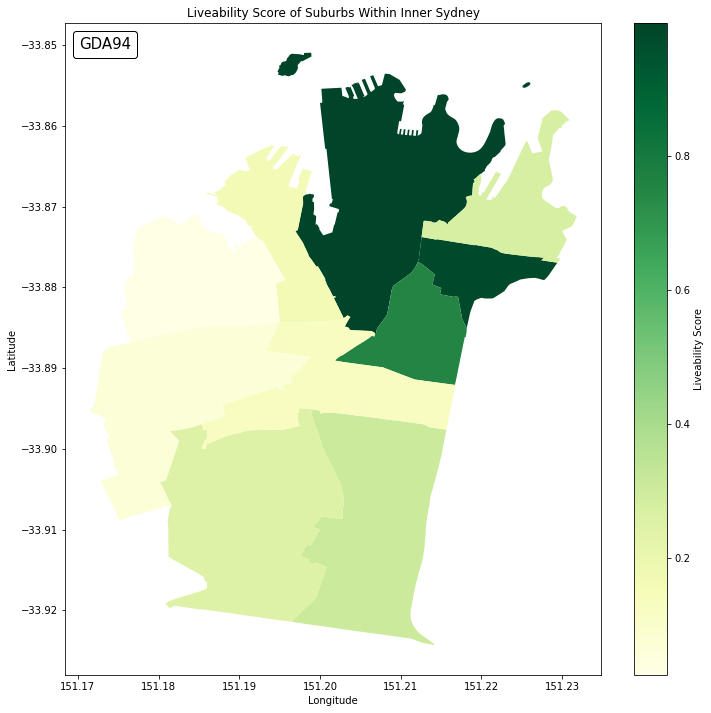

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
adjusted_geom_df.plot(
    ax=ax,
    cmap="YlGn",
    column="adjusted_score",
    legend=True,
    legend_kwds={"label": "Liveability Score"}
)

ax.set_title("Liveability Score of Suburbs Within Inner Sydney")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal", adjustable="box")
ax_mark_gda94(ax)

plt.plot();

In [82]:
savefig(fig, ax)

saved to fig/liveability_score_of_suburbs_within_inner_sydney.png


In [83]:
db.dispose()

Machine Learning
===



We plan on using supervised machine learning to compute a livability score. But first we need a metric to compare against the performance of our model. After some searching in the field, we found the Urban Living Index. We would use this as the target of our machine learning model.

Urban Living Index
---

[<img alt="Urban Living Index logo" src="https://urbanlivingindex.com/wp-content/uploads/2021/08/UrbanLivingIndexLogo.png" width="100px">](https://urbanlivingindex.com/)

> The Urban Living Index measures the urban lifestyle of your suburb.
>
> Check out how your suburb ranks in:
> - Density
> - Urban Living Index
> - Affordability
> - Community
> - Employability
> - Amenity
> - Accessibility

The data we are most interested in is the urban living index by SA2. There is [an embedded interactive map](https://mccrindle.carto.com/builder/6c5ac756-7091-11e5-a49d-0ecd1babdde5/embed) using Carto API.

<img alt="Carto logo" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/CARTO-logo.svg/1200px-CARTO-logo.svg.png" width=100px>
We request the data from its API.

In [84]:
from urllib.request import urlopen

uli_data = []

for x in range(938, 943):
    for y in range(610, 618):
        with urlopen(f"https://a.gusc.cartocdn.com/mccrindle/api/v1/map/mccrindle@e0343114@d08dc4ff06e630c55c122031ecec25b4:1525361026365/2/10/{x}/{y}.grid.json") as url:
            uli_data.append(json.loads(url.read().decode()))

We translate the data into a `pandas.DataFrame`.

In [85]:
uli_df = pd.DataFrame(columns=["index", "index_rank", "sa2"])
for section in uli_data:
    for row in section["data"].values():
        uli_df = uli_df.append(row, ignore_index=True)
uli_df = (
    uli_df
    .drop_duplicates("sa2")
    .sort_values("index_rank")
    .reset_index(drop=True)
    .astype({"index": int, "index_rank": int})
)

Immediately, we see that the Urban Living Index (ULI) uses very different metrics than our livability score. Surry Hills was second to last in our livability score table, but tied for first in this ULI table.

There is are some problems with using this data set.

1. It sometimes uses slightly different SA2 names and merge some areas together.
2. It are no index values for some SA2.

We attempt to resolve the first problem by getting close matches with Python `difflib`.

In [86]:
import difflib

def get_closest_match(s, choices):
    # Get close matches by tokens
    matches = difflib.get_close_matches(s.split(), choices.str.split())
    if matches:
        closest_match = " ".join(matches[0])
        return closest_match
    else:
        return np.NaN

sa2_uli_df = stats_area_df.copy()
sa2_uli_df["uli_name"] = sa2_uli_df["area_name"].apply(get_closest_match, args=(uli_df["sa2"],))

sa2_uli_df = sa2_uli_df.merge(
    uli_df,
    how="left",
    left_on="uli_name",
    right_on="sa2"
)
sa2_uli_df

,area_id,area_name,lvl3_name,geometry,uli_name,index,index_rank,sa2
0,102011028,Avoca Beach - Copacabana,Gosford,"POLYGON ((151.41373 -33.46559, 151.41361 -33.4...",NaN,NaN,NaN,NaN
1,102011029,Box Head - MacMasters Beach,Gosford,"POLYGON ((151.35398 -33.49854, 151.35397 -33.4...",NaN,NaN,NaN,NaN
2,102011030,Calga - Kulnura,Gosford,"MULTIPOLYGON (((151.20460 -33.53298, 151.20456...",NaN,NaN,NaN,NaN
3,102011031,Erina - Green Point,Gosford,"POLYGON ((151.36795 -33.43822, 151.36791 -33.4...",NaN,NaN,NaN,NaN
4,102011032,Gosford - Springfield,Gosford,"POLYGON ((151.31006 -33.42699, 151.31020 -33.4...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
307,128021537,Royal National Park,Sutherland - Menai - Heathcote,"POLYGON ((151.07165 -34.05795, 151.07141 -34.0...",NaN,NaN,NaN,NaN
308,128021538,Sutherland - Kirrawee,Sutherland - Menai - Heathcote,"POLYGON ((151.05049 -34.02006, 151.05098 -34.0...",Sutherland - Kirrawee,62.0000000000,93.0000000000,Sutherland - Kirrawee
309,128021607,Engadine,Sutherland - Menai - Heathcote,"POLYGON ((150.99568 -34.05362, 150.99569 -34.0...",NaN,NaN,NaN,NaN
310,128021608,Loftus - Yarrawarrah,Sutherland - Menai - Heathcote,"POLYGON ((151.03954 -34.04176, 151.03954 -34.0...",NaN,NaN,NaN,NaN


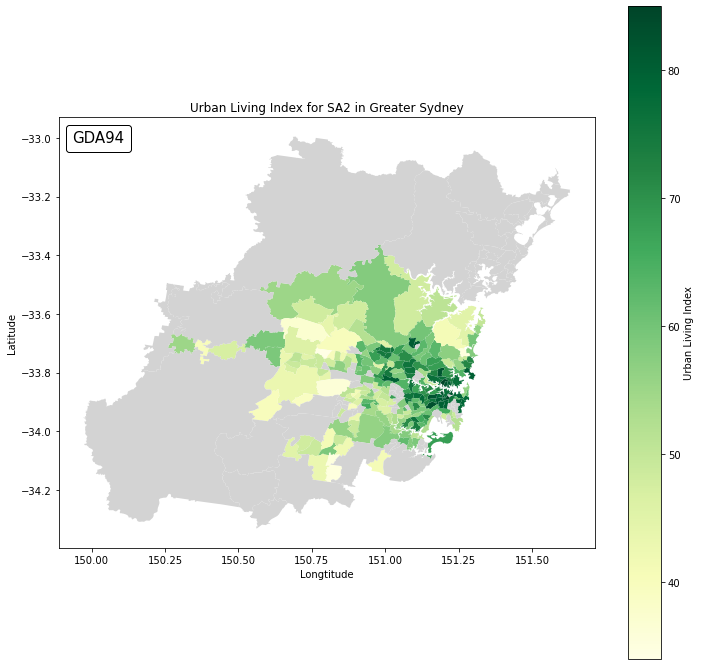

In [87]:
fig, ax = plt.subplots(figsize=(12, 12))

sa2_uli_df.astype({"index": float}).plot(
    ax=ax,
    cmap="YlGn",
    column="index",
    missing_kwds={"color": "lightgrey"},
    legend=True,
    legend_kwds={"label": "Urban Living Index"}
)

ax.set_title("Urban Living Index for SA2 in Greater Sydney")
ax.set_xlabel("Longtitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal", adjustable="box")
ax_mark_gda94(ax)

plt.plot();

Personally, the pattern makes more sense to us because we consider city to be more livable. In the city, we have better access to resources, such as retails, education and health case. Although there are more break and enter cases, to an average person it still feels safe to be living in the City of Sydney.

Linear Regression
---


For the regression of our data, we need to use all the data we have. Our target is the Urban Living Index (ULI).

In [88]:
complete_df = stats_area_df.merge(
    business_stats_raw_df,
    on=["area_id", "area_name"]
).merge(
    neighbourhoods_df,
    on=["area_id", "area_name"]
).merge(
    break_enter_area_df,
    on=["area_id", "area_name"]
).merge(
    catchment_counts_df,
    on=["area_id", "area_name"]
).merge(
    sa2_uli_df,
    on=["area_id", "area_name"]
)

complete_df = complete_df[[
    "area_id",
    "area_name",
    "median_income",
    "avg_monthly_rent",
    "number_of_businesses",
    "crime",
    "count",
    "population",
    "young_pop",
    "index"
]].rename(columns={
    "count": "school_catchment_count",
    "index": "ULI"
})

complete_df["number_of_businesses"] /= complete_df["population"] / 1000
complete_df["crime"] /= complete_df["population"] / 1000
complete_df["school_catchment_count"] /= complete_df["young_pop"] / 1000

complete_df

,area_id,area_name,median_income,avg_monthly_rent,number_of_businesses,crime,school_catchment_count,population,young_pop,ULI
0,102011028,Avoca Beach - Copacabana,46996.0000000000,1906.0000000000,95.3886693017,0.0000000000,2.7100271003,7590,2214,NaN
1,102011029,Box Head - MacMasters Beach,42621.0000000000,1682.0000000000,85.0172947388,0.0000025717,3.0360531309,10986,2635,NaN
2,102011030,Calga - Kulnura,42105.0000000000,1182.0000000000,234.2491220822,0.0000000000,24.5901639344,4841,1098,NaN
3,102011031,Erina - Green Point,43481.0000000000,1595.0000000000,120.2500526796,0.0000015088,5.2680508212,14237,3227,NaN
4,102011032,Gosford - Springfield,45972.0000000000,1382.0000000000,115.1921588857,0.0000455245,3.3183218772,19385,4219,NaN
...,...,...,...,...,...,...,...,...,...,...
306,128021537,Royal National Park,NaN,1899.0000000000,107.1428571429,0.0000000000,2375.0000000000,28,8,NaN
307,128021538,Sutherland - Kirrawee,53378.0000000000,1809.0000000000,98.1617647059,0.0000172060,3.4736411933,21760,4894,62.0000000000
308,128021607,Engadine,52667.0000000000,1955.0000000000,63.4756657484,0.0000039300,2.5115919629,17424,5176,NaN
309,128021608,Loftus - Yarrawarrah,51243.0000000000,2163.0000000000,60.8672232696,0.0000000000,3.8948393379,7426,2054,NaN


We plot a scatter plot matrix to determine if there is any noticeable relationship between any two columns of the data frame.

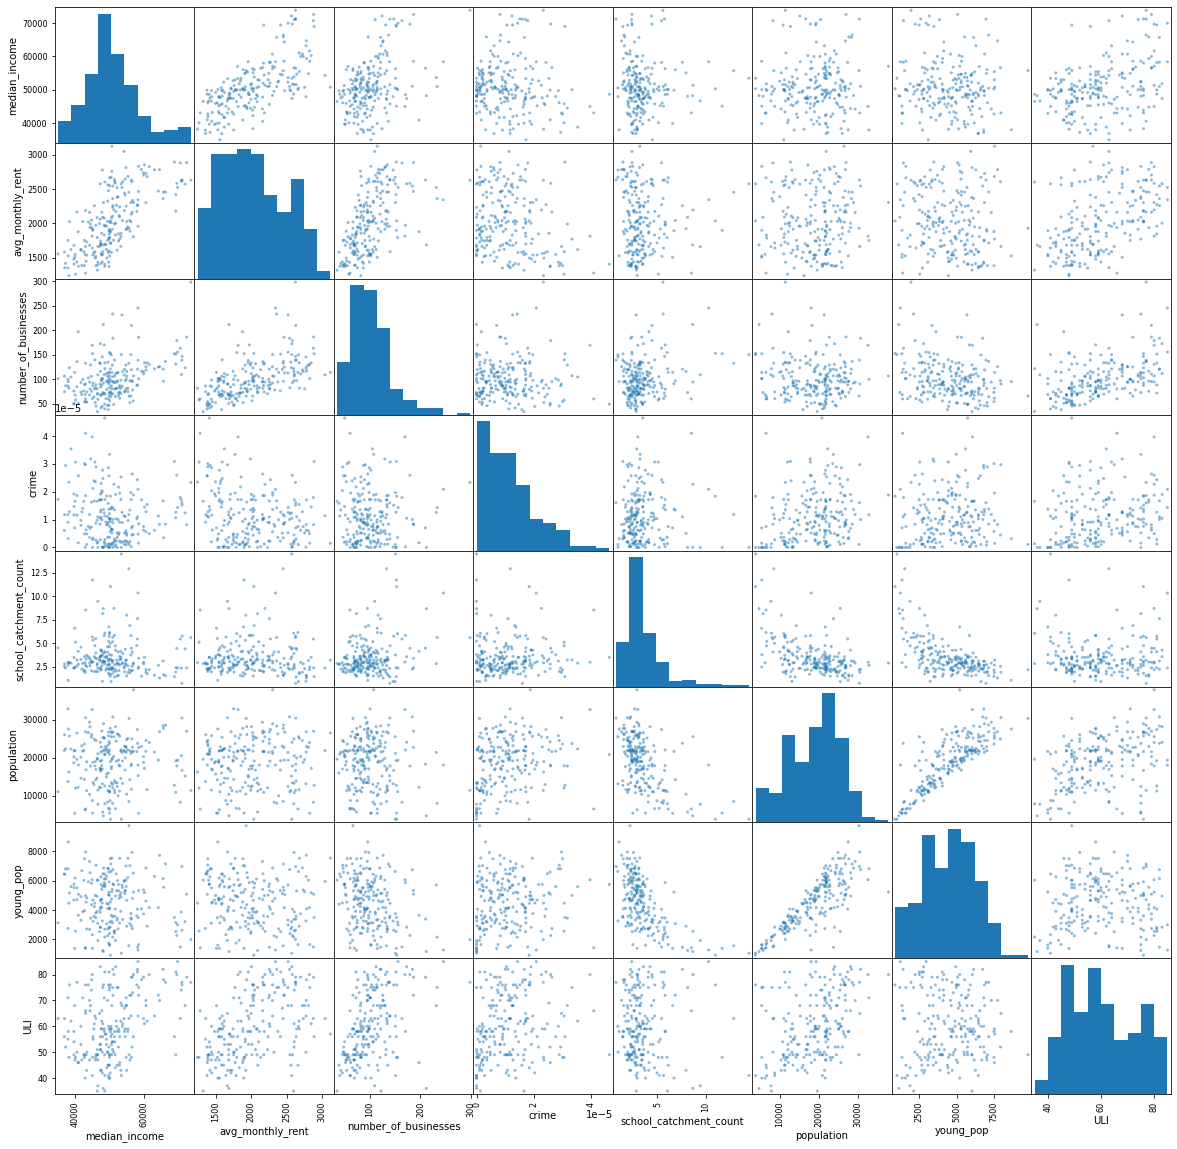

In [89]:
from pandas.plotting import scatter_matrix
from scipy import stats

regression_df = complete_df.iloc[:, 2:].copy()

regression_df.dropna(how="any", inplace=True)

regression_df = regression_df[
    (np.abs(stats.zscore(regression_df)) < 3)
    .all(axis=1)
]

scatter_matrix(regression_df, figsize=(20, 20))

plt.show()

We also show the correlation index between any column and the ULI.

In [90]:
regression_df.corr()["ULI"]

median_income             0.3828144241
avg_monthly_rent          0.4753354094
number_of_businesses      0.4499834929
crime                     0.2151817547
school_catchment_count   -0.0242246857
population                0.4151147081
young_pop                 0.0022160774
ULI                       1.0000000000
Name: ULI, dtype: float64

Without the outliers, the scatter plot matrix show a moderate relationship between some of the columns and the ULI.

In [91]:
from sklearn.linear_model import LinearRegression

X = regression_df.iloc[:, :-1].to_numpy()
y = regression_df.iloc[:, -1].to_numpy()

f"{X.shape = }, {y.shape = }"

'X.shape = (212, 7), y.shape = (212,)'

We use 223 samples with 7 features to train the model.

In [92]:
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.6424583255532721

The model performs somewhat OK.

In [93]:
predict_df = complete_df.copy()

predict_df.dropna(subset=predict_df.columns[2:-1], how="any", inplace=True)

predict_df["LR Score"] = lr.predict(predict_df.iloc[:, 2:-1].to_numpy())
predict_df["LR Score"].clip(0, 100, inplace=True)

predict_df.sort_values("LR Score", ascending=False)

,area_id,area_name,median_income,avg_monthly_rent,number_of_businesses,crime,school_catchment_count,population,young_pop,ULI,LR Score
83,117031337,Sydney - Haymarket - The Rocks,27311.0000000000,2998.0000000000,1358.4650112867,0.0000093123,5.3496369889,31010,2617,77.0000000000,100.0000000000
84,117031338,Waterloo - Beaconsfield,57055.0000000000,2302.0000000000,106.8839146827,0.0000187946,2.8763183126,37929,5215,80.0000000000,95.4256288655
172,121041417,North Sydney - Lavender Bay,71668.0000000000,2749.0000000000,602.7582705813,0.0000073094,2.5380710660,11819,1576,82.0000000000,93.2965460570
79,117031333,Potts Point - Woolloomooloo,58253.0000000000,2256.0000000000,120.7526565584,0.0000109602,7.5914423741,23809,1449,82.0000000000,88.2412838798
82,117031336,Surry Hills,58396.0000000000,2342.0000000000,245.4052258636,0.0000208730,10.3174603175,18064,1260,85.0000000000,86.8848901800
...,...,...,...,...,...,...,...,...,...,...,...
24,102021052,Summerland Point - Gwandalan,42683.0000000000,1455.0000000000,51.1517615176,0.0000008199,1.3917884482,5904,1437,NaN,43.6735439062
5,102011033,Kariong,47896.0000000000,1649.0000000000,53.6697247706,0.0000011140,1.9398642095,6540,2062,NaN,43.4506942443
17,102021045,Blue Haven - San Remo,42641.0000000000,1526.0000000000,27.0983635404,0.0000048167,2.7548209366,11366,3630,NaN,42.1271811241
43,115031299,Bilpin - Colo - St Albans,40176.0000000000,906.0000000000,118.8658669575,0.0000021203,21.1038961039,2751,616,NaN,41.1236647964


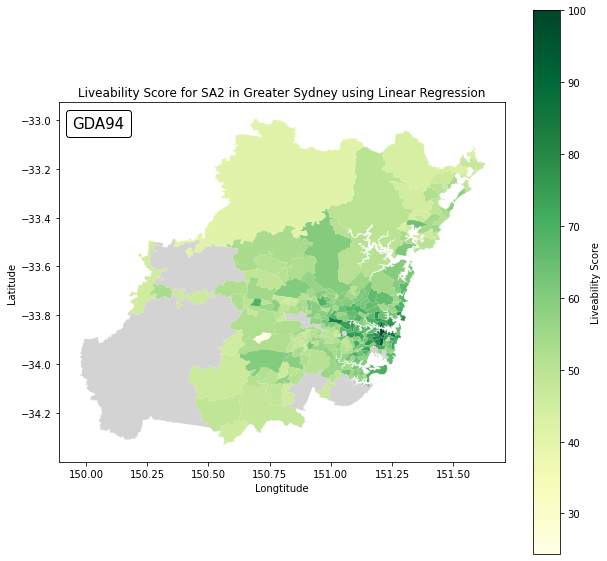

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))

sa2_ls_df = stats_area_df.merge(
    predict_df[["area_id", "LR Score"]],
    how="left"
)

sa2_ls_df.plot(
    ax=ax,
    cmap="YlGn",
    column="LR Score",
    missing_kwds={"color": "lightgrey"},
    legend=True,
    legend_kwds={"label": "Liveability Score"}
)

ax.set_title("Liveability Score for SA2 in Greater Sydney using Linear Regression")
ax.set_xlabel("Longtitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal", adjustable="box")
ax_mark_gda94(ax)

plt.plot();

In [95]:
savefig(fig, ax)

saved to fig/liveability_score_for_sa2_in_greater_sydney_using_linear_regression.png
